In [34]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import newton

In [2]:
from matplotlib import rc

# Configure Matplotlib to use LaTeX
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 18})

In [133]:
def gmom_boundary_n(trSigma, r, n): 
    """
    Boundary of geometric median of means at time n. 
    See Prop 1 in Lugosi and Mendelson survey, https://arxiv.org/pdf/1906.04280
    """ 
    
    return 4*np.sqrt(trSigma*(8*r+1)/n)
    #return 11*np.sqrt(trSigma*(r+np.log(1.4))/n)

def tmom_boundary(trSigma, lambda_max, r, n):
    """
    Boundary of tournament median of means at time n.
    See Theorem 8 in Lugosi and Mendelson survey, https://arxiv.org/pdf/1906.04280
    """

    t1 = 960*np.sqrt(trSigma/n)
    t2 = 240*np.sqrt(lambda_max*(np.log(2) + r) / n)
    return max(t1, t2)


def gmom_union_bound(trSigma, alpha, iters):
    """
    Widths for geometric median-of-means using a 
    naive union bound 
    """
    widths = []
    for t in range(1, iters): 
        alphat = alpha / (t + t**2)
        width = gmom_boundary_n(trSigma, np.log(1/alphat), t)
        widths.append(width)
    return widths

def tmom_union_bound(trSigma, lambda_max, alpha, iters):
    """
    Widths for tournament median-of-means using a
    naive union bound
    """
    widths = []
    for t in range(1, iters): 
        alphat = alpha / (t + t**2)
        width = tmom_boundary(trSigma, lambda_max, np.log(1/alphat), t)
        widths.append(width)
    return widths

def gmom_doubling(trSigma, alpha, iters):
    """
    Widths for geometric median-of-means using the 
    doubling technique of Duchi and Haque. 
    See https://proceedings.mlr.press/v247/duchi24a/duchi24a.pdf, Prop. 16
    """

    widths = []
    for t in range(1, iters): 
        # check if t is a power of 2
        if (t & (t-1)) == 0: 
            rt = np.log(1/alpha) + 2*np.log(np.log2(t)+1) + np.log(np.pi**2/6)
            width = gmom_boundary_n(trSigma, rt, t)
            widths.append(width)
        else: 
            widths.append(widths[-1])
    return widths

def tmom_doubling(trSigma, lambda_max, alpha, iters): 
    """
    Widths for median-of-means using the
    doubling technique of Duchi and Haque. See ref above. 
    """

    widths = []
    for t in range(1, iters): 
        if (t & (t-1)) == 0: 
            rt = np.log(1/alpha) + 2*np.log(np.log2(t)+1) + np.log(np.pi**2/6)
            width = tmom_boundary(trSigma, lambda_max, rt, t)
            widths.append(width)
        else: 
            widths.append(widths[-1])
                    
    return widths

def CG_css(v2, alpha, iters): 
    """ 
    Width of sequential Catoni-Giulini estimator. 
    """
    
    v = np.sqrt(v2)
    beta = 4
    top =  beta/2 + np.log(1/alpha)
    bottom = 0 
    widths = []
    for i in range(1,iters): 
        lambda_i = np.sqrt(np.log(1/alpha)/(v2*i*np.log(i+10000)*20)) 
        top += lambda_i**2  * v2 * (2*np.exp(2/beta + 2) +1)
        bottom += lambda_i
        widths.append(top / bottom)

    return widths

def CG_stitched(v2, alpha, iters): 

    v = np.sqrt(v2)
    c = 2**(3/4)
    widths = []
    betat = 4
    
    for t in range(1, iters): 
        rt = np.log(1.65/alpha) + np.log(np.log2(t) + 1)
        if (t & (t-1)) == 0:
            betat = find_minimizer(rt)
        At = 2*np.exp(2/betat + 2) + 1
        width = c * v * np.sqrt(At*(betat/2 + rt)/t)
        widths.append(width)

    return widths 


In [137]:
lambda_max = 1
alpha = 0.05 
iters = 100000 

gmom_naive_tr5 = gmom_union_bound(5, alpha, iters)
gmom_doubling_tr5 = gmom_doubling(5, alpha, iters)
tmom_naive_tr5 = tmom_union_bound(5, lambda_max, alpha, iters)
tmom_doubling_tr5 = tmom_doubling(5, lambda_max, alpha, iters)
CG_tr5 = CG_css(5, alpha, iters)
CG_stitched_tr5 = CG_stitched(5, alpha, iters)

gmom_naive_tr10 = gmom_union_bound(5, alpha, iters)
gmom_doubling_tr10 = gmom_doubling(5, alpha, iters)
CG_tr10 = CG_css(5, alpha, iters)
CG_stitched_tr10 = CG_stitched(5, alpha, iters)


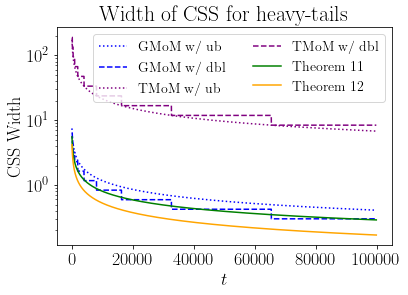

In [138]:
start = 150 

plt.plot(gmom_naive_tr5[start:], ls=":", c='blue', label='GMoM w/ ub')
plt.plot(gmom_doubling_tr5[start:], ls='--', c='blue', label='GMoM w/ dbl')
plt.plot(tmom_naive_tr5[start:], ls=":", c='purple', label='TMoM w/ ub')
plt.plot(tmom_doubling_tr5[start:], ls='--', c='purple', label='TMoM w/ dbl')
plt.plot(CG_tr5[start:], c='green', label='Theorem 11') 
plt.plot(CG_stitched_tr5[start:], c='orange', label='Theorem 12')


plt.legend(fontsize=14, ncol=2)
plt.yscale('log')
plt.xlabel('$t$')
plt.ylabel('CSS Width')
plt.title('Width of CSS for heavy-tails')

plt.savefig('figures/heavy_tails_gmom.png', dpi=300, bbox_inches='tight')


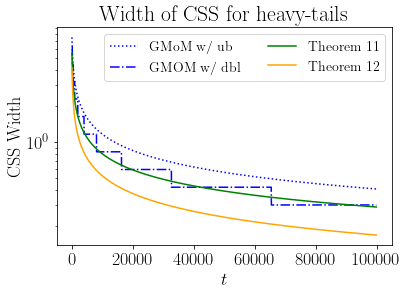

In [140]:
start = 150 


plt.plot(gmom_naive_tr10[start:], ls=':', c='blue', label='GMoM w/ ub')
plt.plot(gmom_doubling_tr10[start:], ls='-.', c='blue', label='GMOM w/ dbl')
plt.plot(CG_tr10[start:], c='green', label='Theorem 11') # label='$d=20$')
plt.plot(CG_stitched_tr10[start:], c='orange', label='Theorem 12') # label='$d=20$')


plt.legend(fontsize=14, ncol=2)

plt.yscale('log')
plt.xlabel('$t$')
plt.ylabel('CSS Width')
plt.title('Width of CSS for heavy-tails')

plt.savefig('figures/heavy_tails.png', dpi=300, bbox_inches='tight')


In [42]:
def fprime_zero(x, r):
    """
    Returns the value of the derivative equation set to zero:
      ( (4/x) + (8*r / x^2) - 2 ) * exp(2 + 2/x ) - 1 = 0
    We want to find x > 0 that makes this expression approximately zero.
    """
    return ((4/x) + (8*r/(x**2)) - 2) * np.exp(2 + 2/x) - 1


def find_minimizer(r, x0=1.0):
    """
    Use a root-finding method to solve fprime_zero(x, r)=0.
    Inputs:
      r   : constant in the original function
      x0  : initial guess for x
    Returns:
      x   : approximate solution (x > 0) that minimizes f(x).
    """
    # newton() will attempt to find a root near x0.
    # Make sure x0 > 0.
    if x0 <= 0:
        raise ValueError("Initial guess x0 must be positive.")
    
    root = newton(fprime_zero, x0, args=(r,))
    if root <= 0:
        return 4
    return root 


1
2
4
8
16
32
64
128
256
512
1024
2048
4096
8192
16384
32768
65536


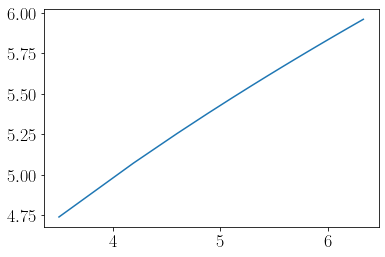

In [45]:

it_log = []
roots = []
for t in range(1, iters):
    if (t & (t-1)) == 0: 
        print(t)
        rt = np.log(1.65/alpha) + np.log(np.log2(t)+1)
        root = find_minimizer(rt)
        it_log.append(rt)
        roots.append(root)

plt.plot(it_log, roots) 




In [41]:
roots

[None, None, None, None, None, None, None, None, None]